In [7]:
import numpy as np
import pandas as pd
from laser_core.propertyset import PropertySet
import matplotlib.pyplot as plt
import itertools
import math
from scipy.optimize import fsolve
import scipy.fftpack as fftpack

from laser_generic import Model
from laser_generic import Infection
from laser_generic import Susceptibility
from laser_generic import Transmission
from laser_generic import Births_ConstantPop
from laser_generic.importation import Infect_Random_Agents

from laser_generic.utils import set_initial_susceptibility_randomly
from laser_generic.utils import seed_infections_randomly

f"{np.__version__=}"

"np.__version__='1.26.4'"

OK, in testing here, we run into a couple of challenges, and my training in spectral
analysis is a bit old at this point.  Mainly, we're interested in relatively low-frequency
signals relative to our vector length - periods that can be order a few years in a sequence of a few decades,
so only a few oscillations.  Not impossible but tough
Second is that there are lots of other signals that will probably settle down over
time, but may not.  Lastly, there seem to be some windowing effects from the length of the
vector itself.
So some approaches to get arounds this:
Try to start relatively close to equilibrium
Use time-domain autocorrelation spectrum 
Instead of looking for the period of maximum power, specifically look for a peak in the vicinity of 
the expected period.


In [8]:
scenario = pd.DataFrame(data=[["homenode", 2e6, "47°36′35″N 122°19′59″W"]], columns=["name", "population", "location"])
parameters = PropertySet({"seed": 4, "nticks": 36500, "verbose": True, "beta": 0.4, "inf_mean": 12, "cbr": 45, "importation_period": 180, "importation_count": 3})

2024-12-17 21:56:11.100352: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-17 21:56:11.154778: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [09:34<00:00, 63.53it/s]


Completed the generic model at 2024-12-17 22:05:45.659989…
Model               :       255,627 µs
Births_ConstantPop  :     3,361,953 µs
Susceptibility      :    57,419,041 µs
Transmission        :   473,633,359 µs
Infection           :    33,829,384 µs
Infect_Random_Agents:       105,812 µs
Total:                  568,605,176 microseconds
2024-12-17 22:05:45.733814: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-17 22:05:45.774587: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [10:47<00:00, 56.34it/s]


Completed the generic model at 2024-12-17 22:16:33.575132…
Model               :       275,668 µs
Births_ConstantPop  :     3,442,635 µs
Susceptibility      :    57,358,038 µs
Transmission        :   547,482,742 µs
Infection           :    32,889,989 µs
Infect_Random_Agents:       102,094 µs
Total:                  641,551,166 microseconds
2024-12-17 22:16:33.642948: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-17 22:16:33.695867: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [08:31<00:00, 71.33it/s]

Completed the generic model at 2024-12-17 22:25:05.402081…
Model               :       235,775 µs
Births_ConstantPop  :     3,851,742 µs
Susceptibility      :    57,198,100 µs
Transmission        :   410,155,168 µs
Infection           :    34,783,170 µs
Infect_Random_Agents:       102,043 µs
Total:                  506,325,998 microseconds
2024-12-17 22:25:05.469218: Creating the generic model…
Initializing the generic model with 1 patches…


2024-12-17 22:25:05.515611: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [10:21<00:00, 58.69it/s]

Completed the generic model at 2024-12-17 22:35:27.432369…
Model               :       258,749 µs
Births_ConstantPop  :     4,122,663 µs
Susceptibility      :    57,326,190 µs
Transmission        :   521,525,469 µs
Infection           :    32,583,433 µs
Infect_Random_Agents:       107,813 µs
Total:                  615,924,317 microseconds
2024-12-17 22:35:27.499426: Creating the generic model…
Initializing the generic model with 1 patches…


2024-12-17 22:35:27.541092: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [13:19<00:00, 45.64it/s]

Completed the generic model at 2024-12-17 22:48:47.199180…
Model               :       289,515 µs
Births_ConstantPop  :     3,635,232 µs
Susceptibility      :    57,440,573 µs
Transmission        :   698,321,242 µs
Infection           :    32,613,323 µs
Infect_Random_Agents:       103,008 µs
Total:                  792,402,893 microseconds
2024-12-17 22:48:47.265524: Creating the generic model…
Initializing the generic model with 1 patches…


2024-12-17 22:48:47.312450: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [12:42<00:00, 47.90it/s]

Completed the generic model at 2024-12-17 23:01:29.338327…
Model               :       296,860 µs
Births_ConstantPop  :     4,930,009 µs
Susceptibility      :    57,405,624 µs
Transmission        :   655,084,413 µs
Infection           :    36,764,319 µs
Infect_Random_Agents:       106,357 µs
Total:                  754,587,582 microseconds
2024-12-17 23:01:29.407884: Creating the generic model…
Initializing the generic model with 1 patches…


2024-12-17 23:01:29.456787: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [07:33<00:00, 80.47it/s]

Completed the generic model at 2024-12-17 23:09:03.056473…
Model               :       225,006 µs
Births_ConstantPop  :     3,497,782 µs
Susceptibility      :    57,416,560 µs
Transmission        :   351,829,014 µs
Infection           :    35,614,203 µs
Infect_Random_Agents:       102,133 µs
Total:                  448,684,698 microseconds
2024-12-17 23:09:03.123962: Creating the generic model…
Initializing the generic model with 1 patches…


2024-12-17 23:09:03.168725: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [13:07<00:00, 46.33it/s]

Completed the generic model at 2024-12-17 23:22:11.064550…
Model               :       284,382 µs
Births_ConstantPop  :     3,799,562 µs
Susceptibility      :    57,793,702 µs
Transmission        :   685,981,611 µs
Infection           :    32,661,634 µs
Infect_Random_Agents:       102,162 µs
Total:                  780,623,053 microseconds
2024-12-17 23:22:11.132837: Creating the generic model…
Initializing the generic model with 1 patches…


2024-12-17 23:22:11.179450: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [06:23<00:00, 95.27it/s] 


Completed the generic model at 2024-12-17 23:28:34.307759…
Model               :       205,195 µs
Births_ConstantPop  :     3,128,330 µs
Susceptibility      :    57,959,486 µs
Transmission        :   283,156,470 µs
Infection           :    34,084,971 µs
Infect_Random_Agents:       109,943 µs
Total:                  378,644,395 microseconds
2024-12-17 23:28:34.374572: Creating the generic model…
Initializing the generic model with 1 patches…
2024-12-17 23:28:34.429589: Running the generic model for 36500 ticks…


100%|██████████| 36500/36500 [10:08<00:00, 59.98it/s]


Completed the generic model at 2024-12-17 23:38:42.973616…
Model               :       263,527 µs
Births_ConstantPop  :     3,381,685 µs
Susceptibility      :    57,264,318 µs
Transmission        :   508,739,374 µs
Infection           :    32,968,346 µs
Infect_Random_Agents:       101,055 µs
Total:                  602,718,305 microseconds


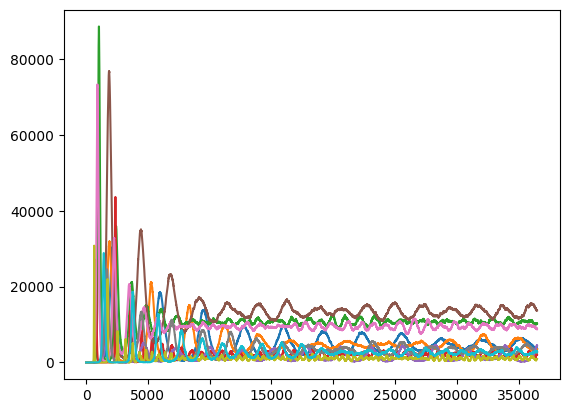

In [9]:
cbrs = 15+85*np.random.rand(10)
inf_means = 5+45*np.random.rand(10)
R0s = 1.5+8.5*np.random.rand(10)
mu = [((1+cbr/1000)**(1/365)-1) for cbr in cbrs]
A = [1/(R0*mu) / 365 for R0, mu in zip(R0s, mu)]
G = [1/(mu + 1/inf_mean) / 365 for mu, inf_mean in zip(mu, inf_means)]
params_df = pd.DataFrame({
    'cbr': cbrs,
    'inf_mean': inf_means,
    'R0': R0s,
    'A': A,
    'G': G,
    'T_exp': T_exp,
})
params_df.to_csv('parameters.csv', index=False)
i = 0
for cbr, inf_mean, R0 in zip(cbrs, inf_means, R0s):
    mu = ((1+cbr/1000)**(1/365)-1)
    parameters = PropertySet({
        "seed": 2, 
        "nticks": 36500, 
        "verbose": True, 
        "beta": R0*(mu + 1/inf_mean), 
        "inf_mean": inf_mean, 
        "cbr": cbr, 
        "importation_period": 180, 
        "importation_count": 3})
    model = Model(scenario, parameters)
    model.components = [Births_ConstantPop,
        Susceptibility,
        Transmission,
        Infection,
        Infect_Random_Agents,
    ]   


    A = 1/((R0-1)*mu) / 365
    G = 1/(mu + 1/inf_mean) / 365
    T_exp = 2*math.pi*np.sqrt(A*G)

    set_initial_susceptibility_randomly(model, 1/R0+.02)
    seed_infections_randomly(model, ninfections=1)
    model.run()
    plt.plot(model.patches.cases)
    cases_df = pd.DataFrame(model.patches.cases, columns=['cases'])
    cases_df.to_csv('cases'+str(i)+'.csv', index=False)
    i = i+1

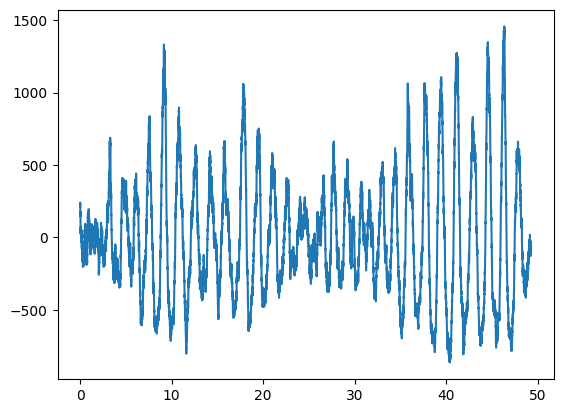

In [72]:


y = model.patches.cases[7300:]
t = np.arange(len(y))
plt.plot(t/365, y-np.mean(y))


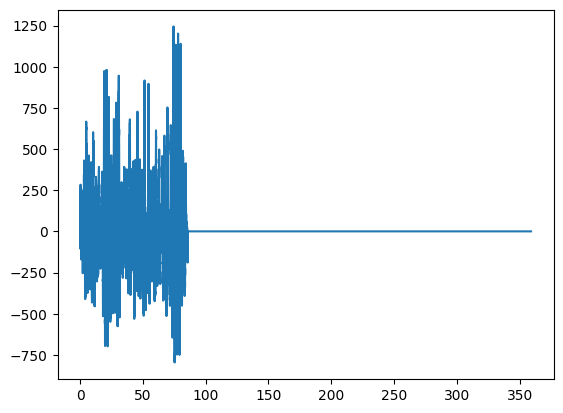

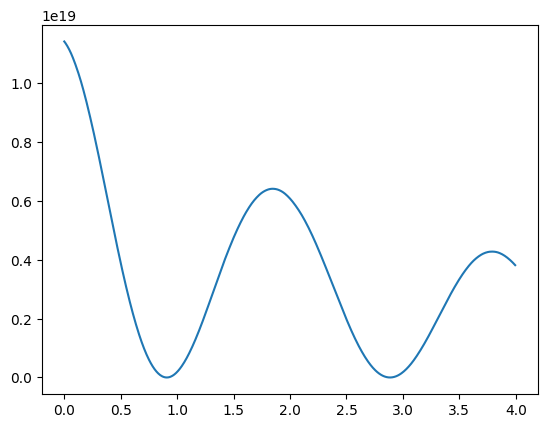

In [104]:
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
parameters['T_obs_peakfinder'] = np.nan
parameters['T_obs_autocorr'] = np.nan

for i in range(10):
    y0 = np.genfromtxt('cases'+str(i)+'.csv', delimiter=',')
    y = y0[7300:]
    y = y-np.mean(y)
    y = gaussian_filter1d(y, sigma=100)
    peaks, _ = find_peaks(y, distance = 300)
    plt.figure()
    plt.plot(y, alpha=0.5)
    plt.plot(peaks, y[peaks], 'x')
    parameters.loc[i, 'T_obs_peakfinder'] = np.median(np.diff(peaks))/365


    # Compute the FFT of the zero-padded signal
    Y1 = np.fft.fft(y0[7300:] - np.mean(y0[7300:]))

    # Compute the circular autocorrelation using the inverse FFT
    circular_autocorr = np.fft.ifft(Y1 * np.conj(Y1)).real
    # Plot only the positive frequency spectrum
    peaks, _ = find_peaks(circular_autocorr, distance = 300)
    parameters.loc[i, 'T_obs_autocorr'] = peaks[0]/365

1.6322099674468922

NameError: name 'plt' is not defined